In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
import tensorflow as tf
print(tf.__version__)

2.0.0-beta1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2019-07-02 23:12:41--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2019-07-02 23:12:42 (116 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



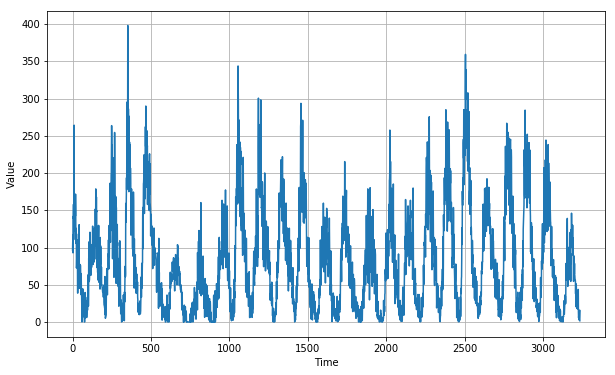

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

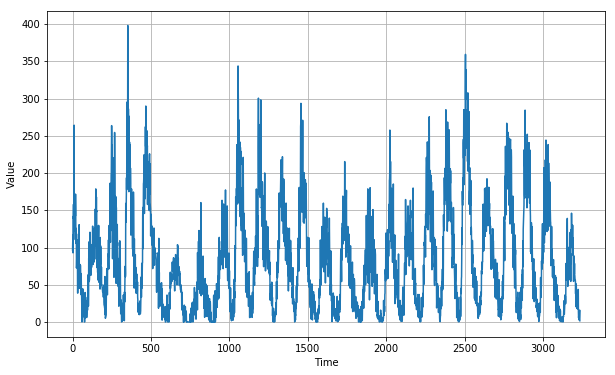

In [28]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [31]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 7s 604ms/step - loss: 79.3289 - mae: 79.6432
Epoch 2/100
12/12 [==============================] - 4s 356ms/step - loss: 77.6025 - mae: 77.9456
Epoch 3/100
12/12 [==============================] - 4s 345ms/step - loss: 75.0294 - mae: 75.3777
Epoch 4/100
12/12 [==============================] - 4s 342ms/step - loss: 71.9486 - mae: 72.2988
Epoch 5/100
12/12 [==============================] - 4s 336ms/step - loss: 68.5473 - mae: 68.8979
Epoch 6/100
12/12 [==============================] - 4s 341ms/step - loss: 64.9847 - mae: 65.3328
Epoch 7/100
12/12 [==============================] - 4s 346ms/step - loss: 61.4695 - mae: 61.8105
Epoch 8/100
12/12 [==============================] - 4s 339ms/step - loss: 58.1538 - mae: 58.4827
Epoch 9/100
12/12 [==============================] - 4s 354ms/step - loss: 55.1324 - mae: 55.4492
Epoch 10/100
12/

[1e-08, 0.0001, 0, 60]

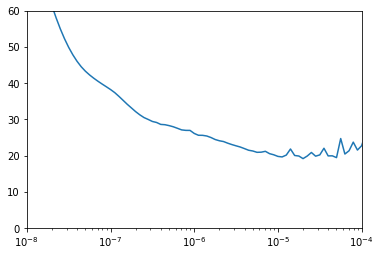

In [32]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 7s 227ms/step - loss: 37.8896 - mae: 38.6059
Epoch 2/500
30/30 [==============================] - 4s 128ms/step - loss: 24.3137 - mae: 24.8470
Epoch 3/500
30/30 [==============================] - 4s 124ms/step - loss: 21.0376 - mae: 21.5412
Epoch 4/500
30/30 [==============================] - 4s 124ms/step - loss: 20.2604 - mae: 20.7556
Epoch 5/500
30/30 [==============================] - 4s 124ms/step - loss: 19.6226 - mae: 20.1157
Epoch 6/500
30/30 [==============================] - 4s 125ms/step - loss: 19.2406 - mae: 19.7160
Epoch 7/500
30/30 [==============================] - 4s 126ms/step - loss: 18.8684 - mae: 19.3572
Epoch 8/500
30/30 [==============================] - 4s 123ms/step - loss: 18.6414 - mae: 19.1303
Epoch 9/500
30/30 [==============================] - 4s 124ms/step - loss: 18.3319 - mae: 18.8184
Epoch 10/500
30/30 [==============================] - 4s 127ms/step - loss: 18.0562 - mae: 18.5398
Epoch 11/500
30/30 

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

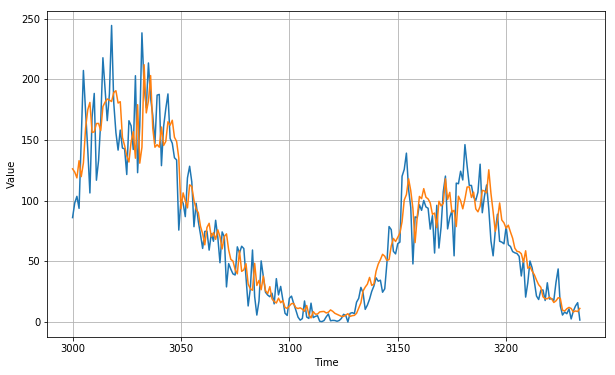

In [40]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [41]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

15.40074

<Figure size 432x288 with 0 Axes>

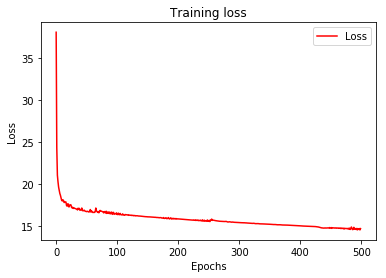

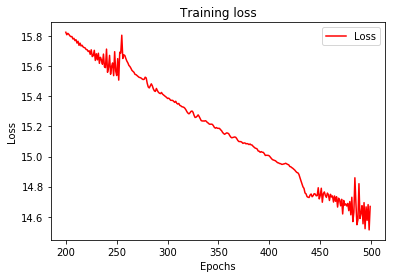

<Figure size 432x288 with 0 Axes>

In [42]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [0]:
print(rnn_forecast)

[1.80334488e+02 1.65932495e+02 2.21385651e+02 2.02602341e+02
 1.95812378e+02 1.66568024e+02 1.72221893e+02 1.72351089e+02
 1.71359238e+02 1.92315262e+02 1.79430908e+02 1.90465561e+02
 1.70150406e+02 1.54548752e+02 1.45760834e+02 1.52615173e+02
 1.56858536e+02 1.52650833e+02 1.31245773e+02 1.35252060e+02
 1.27649216e+02 9.58357544e+01 9.90672379e+01 8.83868637e+01
 8.30485153e+01 8.85051575e+01 8.65534286e+01 8.34583511e+01
 1.14608894e+02 1.31056335e+02 1.32336349e+02 1.03073143e+02
 9.93796616e+01 1.11037933e+02 8.51060486e+01 8.48528519e+01
 7.69715576e+01 6.63921509e+01 5.09542046e+01 4.30102539e+01
 4.26469612e+01 3.53892822e+01 4.97657166e+01 5.25579033e+01
 6.69459915e+01 4.63514252e+01 4.48055305e+01 4.08606110e+01
 4.48441048e+01 3.97551613e+01 2.68832245e+01 2.22263908e+01
 3.32603378e+01 1.98383331e+01 3.29938431e+01 2.01695232e+01
 3.07538300e+01 2.96630077e+01 1.91891308e+01 1.61151085e+01
 1.49790630e+01 1.13105726e+01 6.95184612e+00 1.25114498e+01
 8.35816765e+00 8.356638